# Using Clustering and Pre-trained Networks for Faster Face Detection
In this project the client was building a face detection algorithm to take attendance for employees working in a goverment based buidling. The detection algorithm was too slow so I proposed this solution to make it faster. 
 
     At the end of the notebook I prove how my method makes the process of searching within face embeddings twice as fast.

In [2]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /private/var/folders/19/djb6t8mj2jg637tf964psz500000gn/T/pip-req-build-gixrx9p4
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /private/var/folders/19/djb6t8mj2jg637tf964psz500000gn/T/pip-req-build-gixrx9p4
  fatal: unable to access 'https://github.com/rcmalli/keras-vggface.git/': Could not resolve host: github.com
ERROR: Command errored out with exit status 128: git clone -q https://github.com/rcmalli/keras-vggface.git /private/var/folders/19/djb6t8mj2jg637tf964psz500000gn/T/pip-req-build-gixrx9p4 Check the logs for full command output.


In [3]:
!pip install face-recognition 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline  
from tqdm import tqdm 
import face_recognition
from skimage.io import imread
import cv2

In [10]:
import os 
known_face_encodings = []
known_face_empid = []
known_faces_filenames = []
dirpaths = []
img_full_paths = []
# Walk in the root folder to add every dirname to dirnames
for (dirpath, dirnames, filenames) in os.walk('IDSC\\'):
    # Walk in each dirname (sub-folder) to add every file name to known_faces_filenames
    dirpaths.append(dirpath)
    known_faces_filenames.extend(filenames)
    #loop in the filenames list to concatenate the path string to have the filename full path
    for i in range(len(filenames)):
        img_full_paths.append(dirpath + '\\' + filenames[i])           
        
# loop in all the list of images full file names
for img_full_path in img_full_paths:
    # Load each file
    face = face_recognition.load_image_file(img_full_path)
    #Convert the image to RGB
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    # Encode the faces of every employee
    known_face_encodings.append(face_recognition.face_encodings(face)[0])
    print ('finished encoding ' , img_full_path)
    
# Extract the name_id of each employee and add it to known_face_empid
for filename in known_faces_filenames:
    filename = re.split("_", filename, 1)[0]
    known_face_empid.append(filename)


In [3]:
# for loading/processing the images  
import tensorflow.keras
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import img_to_array 
from tensorflow.keras.applications.vgg16 import preprocess_input 
import tensorflow.keras.preprocessing.image as kp
# models 
from tensorflow.keras.applications.vgg16 import VGG16 
from keras.models import Model
import keras_vggface
from keras_vggface import VGGFace

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


Using TensorFlow backend.


In [4]:
# load the model first and pass as an argument
model = VGGFace(model="resnet50")
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)


In [5]:
def extract_features(image, model):
    # load the image as a 224x224 array
    img = load_img(image, target_size=(224,224))
    # convert to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features


In [11]:
ig=imread(img_full_paths[0])
plt.imshow(ig)

IndexError: list index out of range

In [17]:

#create a dictionary mapping extracted feature to every image 

data={}
for ig in tqdm(images_o[:3000]):
  data[ig]=extract_features(ig,model)







100%|██████████| 3000/3000 [44:27<00:00,  1.12it/s] 


In [18]:
# get a list of the filenames actually used 
filenames = np.array(list(data.keys()))
# get a list of just the features
feat = np.array(list(data.values()))
print(feat.shape)
# reshape so that there are 3000 samples of  2048 vectors
feat = feat.reshape(-1, 2048)
print("features reshaped to ")
feat.shape

(3000, 1, 2048)
features reshaped to 


(3000, 2048)

In [19]:
# use pca dimensionality reduction to reduce size of features extracted 
pca=PCA(n_components=300,random_state=42)
pca.fit(feat)
x=pca.transform(feat)
print(f" Components before PCA : {feat.shape[1]}")
print(f"Components after PCA : {pca.n_components}")

      


 Components before PCA : 2048
Components after PCA : 300


In [20]:
#perform kmeans clsutering 
n=10
kmeans=KMeans(n_clusters=n,n_jobs=-1,random_state=42,max_iter=300)
kmeans.fit(x)
kmeans.labels_

/Users/macbook/Desktop/ll/env/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


array([8, 6, 2, ..., 2, 2, 6], dtype=int32)

In [21]:
# use the dictionary and labels to group images into clusters /groups

groups={}
for img,cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster]=[]
        groups[cluster].append(img)
    else:
        groups[cluster].append(img)


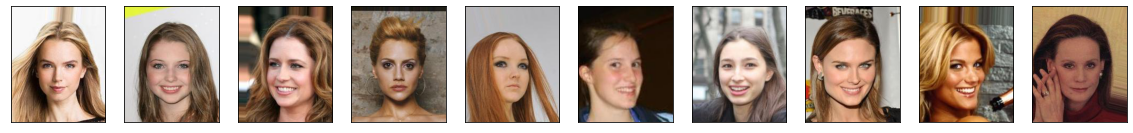

In [25]:
#plot images of clusters to see if they actually look alike 
fig=plt.figure(figsize=(20,20))
for e,i in enumerate(groups[0][:10]):
    img=imread(folder+i)
    ax=plt.subplot(1,10,e+1,xticks=[],yticks=[])
    ax.imshow(img)

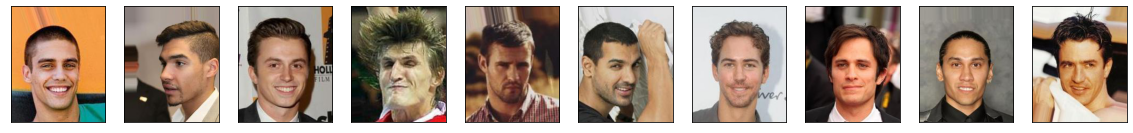

In [29]:
#plot images of clusters to see if they actually look alike 
fig=plt.figure(figsize=(20,20))
for e,i in enumerate(groups[9][:10]):
    img=imread(folder+i)
    ax=plt.subplot(1,10,e+1,xticks=[],yticks=[])
    ax.imshow(img)

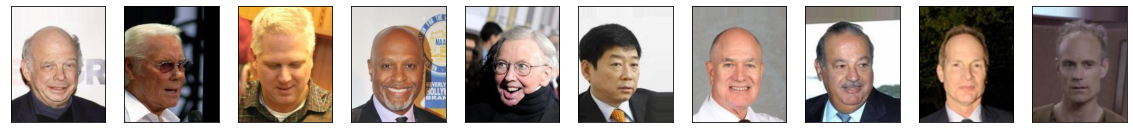

In [30]:
#plot images of clusters to see if they actually look alike 
fig=plt.figure(figsize=(20,20))
for e,i in enumerate(groups[4][:10]):
    img=imread(folder+i)
    ax=plt.subplot(1,10,e+1,xticks=[],yticks=[])
    ax.imshow(img)

In [36]:
known_face_encodings = []
failed=[]
encoded=[]
# loop in all the list of images full file names
for img in tqdm(images_o[:3000]):
    try:
        # Load each file
        face = face_recognition.load_image_file(folder+img)
        #Convert the image to RGB
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        # Encode the faces of every employee
        known_face_encodings.append(face_recognition.face_encodings(face)[0])
        encoded.append(img)
        
    except:
        failed.append(img)
    


100%|██████████| 3000/3000 [03:15<00:00, 15.31it/s]


In [41]:
known_face_empid = []
# Extract the name_id of each employee and add it to known_face_empid
for filename in encoded:
    known_face_empid.append(filename)

In [42]:
print(f" Actually got encoded : {len(encoded)}")
print(f" Failed to be encoded : {len(failed)}")
len(known_face_empid)

 Actually got encoded : 2915
 Failed to be encoded : 85


2915

In [159]:
import time 
start_time=time.time()
img_to_compare=encoded[7]
# Load each file
face = face_recognition.load_image_file(folder+img_to_compare)
#Convert the image to RGB
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
#if process face found:
face_locations = face_recognition.face_locations(face)
face_encodings = face_recognition.face_encodings(face,face_locations)[0]
            
# Loop in every faces detected
# See if the face is a match for the known face(s)
matches = face_recognition.compare_faces(known_face_encodings, face_encodings)
name_id = "Unknown"
# check the known face with the smallest distance to the new face
face_distances = face_recognition.face_distance(known_face_encodings, face_encodings)
# Take the best one
best_match_index = np.argmin(face_distances)
# If we have a match
if matches[best_match_index]:
    # ave the name_id of the best match
    name_id = known_face_empid[best_match_index]
normal_time=time.time()-start_time
print(normal_time)











0.14273810386657715


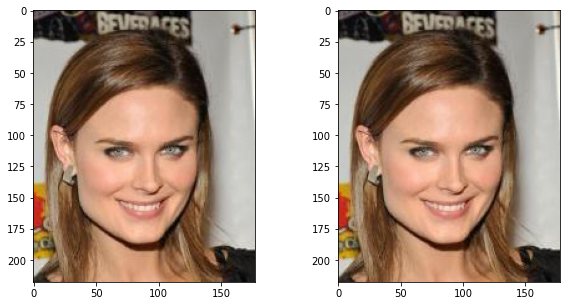

In [160]:
try:
    fig,(ax,ax2)=plt.subplots(ncols=2,figsize=(10,5))
    img_to_compare=imread(folder+img_to_compare)
    ig=imread(folder+name_id)
    ax.imshow(img_to_compare)
    ax2.imshow(ig)
except :
    ax.imshow(img_to_compare)
    print("Unknown")

In [98]:
known_face_encodings_dict = {}
failed=[]
encoded=[]
# loop in all the list of images full file names
for grp in tqdm(range(0,10)):
    known=[]
    for img in groups[grp]:
        try:
            # Load each file
            face = face_recognition.load_image_file(folder+img)
            #Convert the image to RGB
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            # Encode the faces of every employee
            known.append(face_recognition.face_encodings(face)[0])
            encoded.append(img)

        except:
            failed.append(img)
    known_face_encodings_dict[grp]=known


100%|██████████| 10/10 [03:19<00:00, 19.95s/it]


In [100]:
known_face_encodings_dict.keys()


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [133]:
# create a 3d array having encodings of every group and compute each's mean 
means={}
c=0
for grp in tqdm(range(0,n)):
    cnt=0
    group_encodings=known_face_encodings_dict[grp]
    for i in group_encodings:
        if cnt==0:
            en_3d=i
        else:
            en_3d=np.dstack((en_3d,i))
        cnt=cnt+1
            
    mean_of_group=np.mean(en_3d,axis=2).reshape(128,)
    means[grp]=mean_of_group
            

100%|██████████| 10/10 [00:00<00:00, 40.12it/s]


In [161]:
def calculateDistance(i1, i2):
    return np.sum((i1-i2)**2)
start_time=time.time()
img_to_compare=encoded[7]
# Load each file
face = face_recognition.load_image_file(folder+img_to_compare)
#Convert the image to RGB
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
#if process face found:
face_locations = face_recognition.face_locations(face)
face_encodings = face_recognition.face_encodings(face,face_locations)[0]
dist_group=[]
for grp in range(0,n):
    dist_group.append(calculateDistance(means[grp], face_encodings))
best_group=np.argmin(dist_group)



            
# Loop in every faces detected
# See if the face is a match for the known face(s)
matches = face_recognition.compare_faces(known_face_encodings_dict[best_group], face_encodings)
name_id = "Unknown"
# check the known face with the smallest distance to the new face
face_distances = face_recognition.face_distance(known_face_encodings_dict[best_group], face_encodings)
# Take the best one
best_match_index = np.argmin(face_distances)
# If we have a match
if matches[best_match_index]:
    # ave the name_id of the best match
    name_id = groups[best_group][best_match_index]
cluster_time=time.time()-start_time
print(cluster_time)


0.06444382667541504


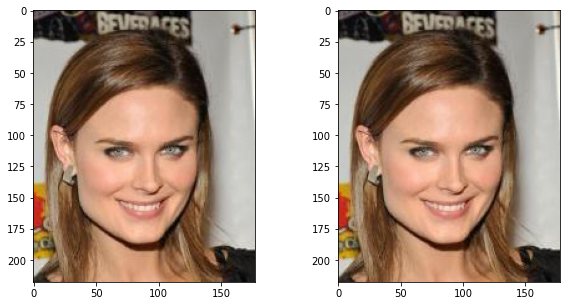

In [162]:
try:
    fig,(ax,ax2)=plt.subplots(ncols=2,figsize=(10,5))
    img_to_compare=imread(folder+img_to_compare)
    ig=imread(folder+name_id)
    ax.imshow(img_to_compare)
    ax2.imshow(ig)
except :
    ax.imshow(img_to_compare)
    print("Unknown")

normal method vs my method?

In [163]:
normal_time/cluster_time

2.2149228441307156